# Environment Setup: Install necessary libraries

In [1]:

!pip install kaggle
!kaggle datasets download -d tubagusaldi/dataset-spiceify
!pip install split-folders


Dataset URL: https://www.kaggle.com/datasets/tubagusaldi/dataset-spiceify
License(s): unknown
 99% 2.13G/2.16G [00:13<00:00, 211MB/s]
100% 2.16G/2.16G [00:13<00:00, 173MB/s]


# Import Libraries

In [2]:

import os
import zipfile
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Prepare Dataset

In [3]:

local_zip = r'/content/dataset-spiceify.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(r'/content/')
zip_ref.close()

In [4]:
capstone_path = '/content/Datasetku3'
input_folder = capstone_path
output_folder = 'dataset_split'

In [5]:
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.7, .3), group_prefix=None)

Copying files: 3600 files [00:12, 296.70 files/s] 


In [6]:
def custom_preprocessing(image):
    # Convert image to tensor
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

In [7]:
base_dir = capstone_path
train_dir = os.path.join(base_dir, '/content/dataset_split/train')
validation_dir = os.path.join(base_dir, '/content/dataset_split/val')

# Applying Data Augmentation

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2519 images belonging to 12 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

Found 1077 images belonging to 12 classes.


# Print number of classes

In [12]:

num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')

Number of classes: 12


# Load VGG16 model, excluding the top layer

In [13]:
# Load VGG16 model, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


# Unfreeze more layers for fine-tuning

In [14]:

for layer in base_model.layers[-8:]:
    layer.trainable = True


In [15]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

# Compile the model with SGD optimizer

In [16]:

model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy']
)

# Early stopping callback

In [17]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model

In [18]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
38/78 [=============>................] - ETA: 32s - loss: 3.0019 - accuracy: 0.1423

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


78/78 [==============================] - 113s 1s/step - loss: 2.6316 - accuracy: 0.2835 - val_loss: 1.7059 - val_accuracy: 0.6061
Epoch 2/50
78/78 [==============================] - 108s 1s/step - loss: 1.7563 - accuracy: 0.5943 - val_loss: 1.3194 - val_accuracy: 0.7083
Epoch 3/50
78/78 [==============================] - 87s 1s/step - loss: 1.3046 - accuracy: 0.7366 - val_loss: 1.1420 - val_accuracy: 0.7831
Epoch 4/50
78/78 [==============================] - 85s 1s/step - loss: 1.1863 - accuracy: 0.7893 - val_loss: 1.0564 - val_accuracy: 0.8409
Epoch 5/50
78/78 [==============================] - 88s 1s/step - loss: 1.0643 - accuracy: 0.8323 - val_loss: 1.0905 - val_accuracy: 0.8239
Epoch 6/50
78/78 [==============================] - 85s 1s/step - loss: 1.0176 - accuracy: 0.8347 - val_loss: 0.9102 - val_accuracy: 0.8769
Epoch 7/50
78/78 [==============================] - 90s 1s/step - loss: 0.9221 - accuracy: 0.8717 - val_loss: 1.0185 - val_accuracy: 0.8447
Epoch 8/50
78/78 [===========

# Plotting the training and validation accuracy and loss

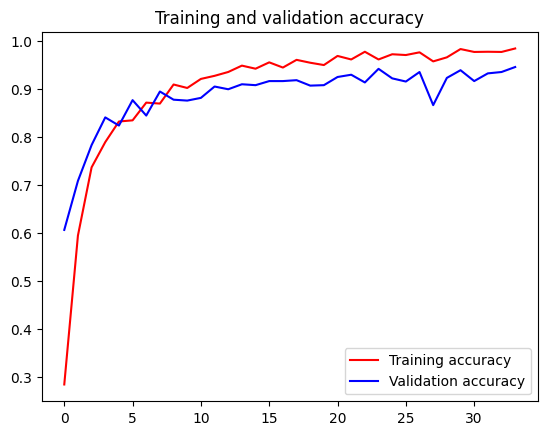

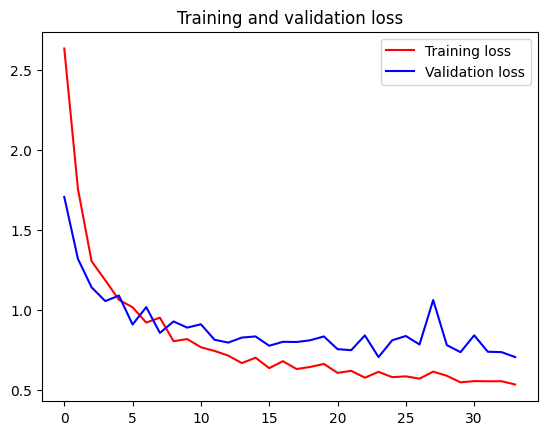

In [19]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Save the model

In [20]:

model.save('spice_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Convert the model to TensorFlow Lite

In [21]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Save the TensorFlow Lite model to a file

In [22]:

with open('spice_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [23]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/spice_classifier_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Predict Image

In [24]:

def load_image(img_path):
    img = Image.open(img_path).resize((150, 150))
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img



In [26]:
# Mendapatkan label kelas
labels = train_generator.class_indices
# Membalik dictionary untuk mendapatkan label dari indeks
labels = {v: k for k, v in labels.items()}
print(labels)

def predict_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPG"):
            image_path = os.path.join(folder_path, filename)
            image = load_image(image_path)

            interpreter.set_tensor(input_details[0]['index'], image)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_class = np.argmax(output_data)
            print(f"File: {filename}, Predicted Class: {predicted_class} ({labels[predicted_class]})")

folder_path = '/content/test/'
predict_images_in_folder(folder_path)


{0: 'Andaliman', 1: 'Cengkeh', 2: 'Daun Salam', 3: 'Jahe', 4: 'Kemiri', 5: 'Kencur', 6: 'Ketumbar', 7: 'Lengkuas', 8: 'daunjeruk', 9: 'kayumanis', 10: 'kunyit', 11: 'pala'}
File: daun salam 5.jpg, Predicted Class: 2 (Daun Salam)
File: lengkuas 4.jpg, Predicted Class: 7 (Lengkuas)
File: daun salam 3.jpg, Predicted Class: 2 (Daun Salam)
File: kayu manis.jpg, Predicted Class: 9 (kayumanis)
File: kemiri 8.jpg, Predicted Class: 4 (Kemiri)
File: kemiri 5.JPG, Predicted Class: 4 (Kemiri)
File: jahe 5.jpg, Predicted Class: 3 (Jahe)
File: daun jeruk 5.jpg, Predicted Class: 8 (daunjeruk)
File: jahe.jpg, Predicted Class: 3 (Jahe)
File: kemiri 6.JPG, Predicted Class: 11 (pala)
File: cengkeh 3.jpg, Predicted Class: 1 (Cengkeh)
File: daun salam 2.jpg, Predicted Class: 2 (Daun Salam)
File: jahe 3.jpg, Predicted Class: 5 (Kencur)
File: jahe 4.jpg, Predicted Class: 3 (Jahe)
File: kemiri 3.jpg, Predicted Class: 5 (Kencur)
File: daun jeruk 4.jpg, Predicted Class: 8 (daunjeruk)
File: kayu manis 2.jpg, Pre